# An example of implementing the Re-QGAN

In [11]:
from qGAN import * 
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from sklearn.decomposition import PCA
#
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Constants
a = 0.001
b = 0.01
c= 0.01
T_HPC_node = 0.05

# Node-hours for each qubit size
def node_hours_updated(N, nodes_required):
    T_QAOA = a * N**2 
    T_AQCG =  2000 * b * N
    T_ASC =  2000 * c * N
    total_time = T_QAOA + T_AQCG + T_ASC
    return (total_time / T_HPC_node) * nodes_required
def memory_and_nodes(N, chi):
    M = 2*N*chi**2
    return np.ceil(M/(512*1024 + 96*1024))

# Calculate total node hours
total_node_hours_updated = 0
for N in range(50, 101, 10):
    nodes_required = memory_and_nodes(N, 10)
    total_node_hours_updated += node_hours_updated(N, nodes_required)

# Add 5% for testing
total_node_hours_updated *= 1.05
print(total_node_hours_updated)

378745.5


# Training Re-QGAN

In [13]:
"""
n_q : number of qubits to use for the generator. 
n_comp_max : number of mnist images to train the re-qgan on.
idx: the specific digit to train re-qgan on.
epochs: The number of epochs the re-qgan runs for.
"""
import datetime
n_q = 2 
shape = 'digits'
digit = 0
n_comp_max = 100
backend = 'fake_bogota'
opt_maxevals = 5000
epochs = 25
# today's date
date = datetime.datetime.today().strftime('%Y-%m-%d')
#
data, data_decomp, pca_ = reduced_data(n_q=n_q, shape=shape, n_comp_max=n_comp_max, idx = digit) 
algo = qgan(qubits = [i for i in range(n_q)], data = data, backend = 'fake_bogota', qc_real_build=False, mock_backend=False, opt_maxevals=opt_maxevals)
output  = algo.game(epochs=epochs)
# store the output in the results folder, use the experiment info to create the file name, include the n_q, n_comp_max, idx, epochs, date, and backend used.
pickle.dump(output, open('results/reqgan_{}_{}_{}_{}_{}_{}.pkl'.format(n_q, n_comp_max, digit, epochs, date, backend), 'wb'))


####################
epoch : 0
disc training
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 9 (seed=496545, Tue Nov  7 11:29:10 2023)
  626   5008 2.775226451928856e-01 2.1e+02 7.31e-02  1e-02  7e-02 21:37.4
gen training
(10_w,21)-aCMA-ES (mu_w=6.2,w_1=27%) in dimension 300 (seed=421055, Tue Nov  7 11:50:48 2023)
  239   5019 4.588281787443098e-01 1.3e+00 7.26e-02  7e-02  7e-02 6:27.5
####################
epoch : 1
disc training
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 9 (seed=543487, Tue Nov  7 11:57:15 2023)
  626   5008 1.729591030241220e-01 5.7e+02 2.04e-02  5e-03  5e-02 21:36.2
gen training
(10_w,21)-aCMA-ES (mu_w=6.2,w_1=27%) in dimension 300 (seed=564993, Tue Nov  7 12:18:51 2023)
  239   5019 5.618833300053093e-01 1.3e+00 7.62e-02  8e-02  8e-02 6:26.3
####################
epoch : 2
disc training
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 9 (seed=456356, Tue Nov  7 12:25:18 2023)
  505   4040 3.642443537912232e-01 1.3e+02 8.54e-02  2e-02  1e-01 17:22.4
gen training


# Plotting the output from Re-QGAN

In [1]:
fig, (ax0, ax1) = plt.subplots(2,10,figsize=(20,5))
for idx, img_ in enumerate(data_decomp):
    ax0[idx].imshow(img_.reshape([28,28]), cmap = 'gray')
    ax0[idx].axis('off')

ws = output.get('gen_pca_img')
ws_ = []
for w in ws:
    w_ = pca_.inverse_transform(w)
    w_ = w_.reshape([28,28])*255
    ws_.append(w_)
n_plots = len(ws_)
for idx, im in enumerate(ws_):
    ax1[idx].imshow(im, cmap = 'gray')
    ax1[idx].axis('off')

NameError: name 'plt' is not defined

# Plotting Outputs from different epochs

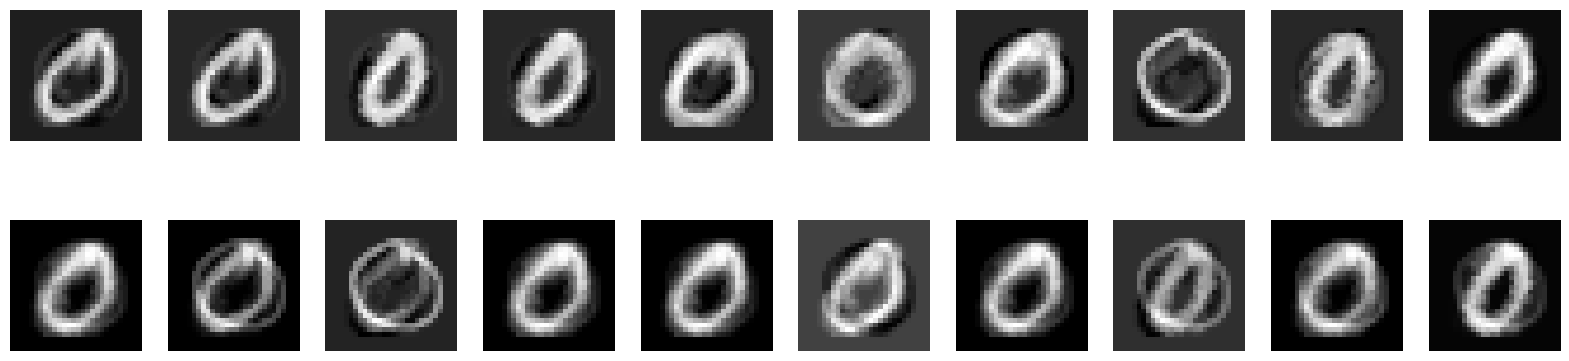

In [4]:
gen_h = output.get('w_gen_hist')

n_epoch = 4 #The epoch whose output we want to print
hs = gen_h[n_epoch]
hs_ = []
for h in hs:
    h_ = pca_.inverse_transform(h)
    h_ = h_.reshape([28,28])*255
    hs_.append(h_)

fig, (ax0, ax1) = plt.subplots(2,10,figsize=(20,5))
for idx, img_ in enumerate(data_decomp):
    ax0[idx].imshow(img_.reshape([28,28]), cmap = 'gray')
    ax0[idx].axis('off')



for idx, im in enumerate(hs_):
    ax1[idx].imshow(im, cmap = 'gray')
    ax1[idx].axis('off')


# Loss Functions Plots at different epochs

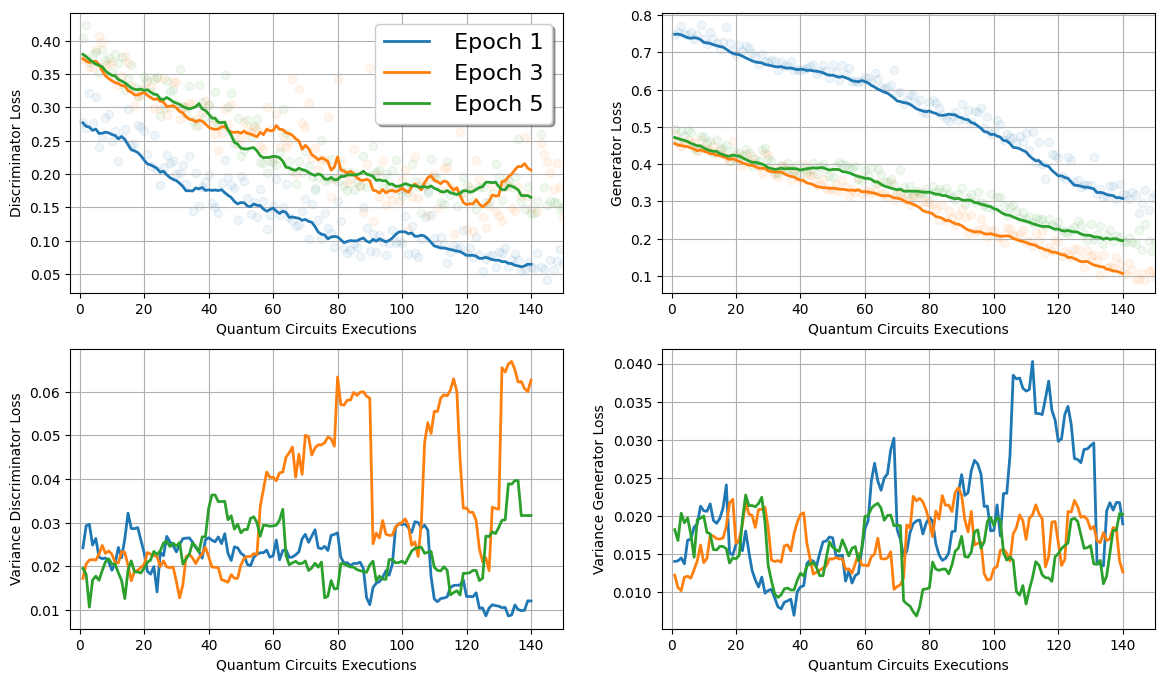

In [5]:
gen_data = output.get('gen_data')
x_gen_hist = output.get('x_gen_hist')
disc_training = output.get('disc_training')
gen_training = output.get('gen_training')

disc_train = np.array(disc_training)
gen_train = np.array(gen_training)

def mean_plot(data, window = 11):
    average_cost = []
    for ind in range(150 - window + 1):
        average_cost.append(np.mean(data[ind:ind+window]))
    return average_cost

def variance_plot(data, window = 11):
    variance_cost = []
    for ind in range(150 - window + 1):
        variance_cost.append(np.std(data[ind:ind+window]))
    return variance_cost


data =  [disc_train[0,i] for i in range(150)]
mean_data = mean_plot(data)    


fig, (ax1, ax2) = plt.subplots(2, 2, figsize= (14,8))
window = 11
xx = [i+1 for i in range(150)]
xx_ = [i+1 for i in range(150 - window + 1)]
for epoch in [0,2,4]:
    data =  [disc_train[epoch,i] for i in range(150)]
    data = np.array(data)
    mean_data = mean_plot(data)
    mean_data = np.array(mean_data)
    ax1[0].scatter(xx, data, marker = 'o', alpha = 0.07)
    ax1[0].plot(xx_, mean_data, lw = 2, label = ' Epoch '+str(epoch+1))
    mean_data = variance_plot(data)
    ax2[0].plot(xx_, mean_data, lw = 2, label = ' Epoch '+str(epoch+1))
    data =  [gen_train[epoch,i] for i in range(150)]
    mean_data = mean_plot(data)
    data = np.array(data)
    mean_data = np.array(mean_data)
    ax1[1].scatter(xx, data, marker = 'o', alpha = 0.07)
    ax1[1].plot(xx_, mean_data, lw = 2, label = ' Epoch '+str(epoch+1))
    mean_data = variance_plot(data)
    ax2[1].plot(xx_, mean_data, lw = 2, label = ' Epoch '+str(epoch+1))

axis_font = {'fontname':'Times New Roman', 'size':'20'}
ax1[0].set_xlabel(r'Quantum Circuits Executions' )
ax2[0].set_xlabel(r'Quantum Circuits Executions' )
ax1[1].set_xlabel(r'Quantum Circuits Executions' )
ax2[1].set_xlabel(r'Quantum Circuits Executions' )

ax1[0].set_ylabel(r'Discriminator Loss' )
ax1[1].set_ylabel(r'Generator Loss')
ax2[0].set_ylabel(r'Variance Discriminator Loss' )
ax2[1].set_ylabel(r'Variance Generator Loss')

ax1[0].set_xlim((-3,150))
ax2[0].set_xlim((-3,150))
ax1[1].set_xlim((-3,150))
ax2[1].set_xlim((-3,150))

ax1[0].legend(fontsize=16, shadow=True)
ax1[0].grid(True)
ax1[1].grid(True)
ax2[0].grid(True)
ax2[1].grid(True)

In [10]:
import logging
import os
import numpy as np
import tensorflow as tf

if os.getcwd().split(os.sep)[-1] == 'notebook':
    os.chdir('..')

from cma import CMA


def main():
    logging.basicConfig(level=logging.INFO, format="%(asctime)s (%(levelname)s) %(message)s")

    tf.random.set_seed(123)

    max_epochs = 500

    log_dir = 'logs/griewank_function'
    summary_writer = tf.summary.create_file_writer(log_dir)

    def logging_function(cma, logger):
        fitness = cma.best_fitness()

        # Write best fitness to the tensorboard summary log
        with summary_writer.as_default():
            tf.summary.scalar('fitness', fitness, step=cma.generation)

        # Periodically log progress
        if cma.generation % 10 == 0:
            logger.info(f'Generation {cma.generation} - fitness {fitness}')

        if cma.termination_criterion_met or cma.generation == max_epochs:
            sol = cma.best_solution()
            logger.info(f'Final solution at gen {cma.generation}: {sol} (fitness: {fitness})')

    cma = CMA(
        initial_solution=[100.] * 10,
        initial_step_size=600.,
        fitness_function=fitness_fn,
        enforce_bounds=[[-600, 600]] * 10,
        callback_function=logging_function,
    )
    with tf.device('/GPU:0'):
        cma.search(max_epochs)


def fitness_fn(x):
    """
    Griewank Function
    https://www.sfu.ca/~ssurjano/griewank.html
    """
    dimension = tf.shape(x)[1].numpy()

    s, p = [], []
    for i in range(dimension):
        s.append(x[:,i]**2)
        #p.append(tf.cos(x[:,i] / tf.sqrt(tf.cast(i, dtype=tf.float64) + 1)))
        p.append(tf.cos(x[:,i] / tf.sqrt(tf.cast(i, dtype=tf.float32) + 1)))
    return 1. + (1. / 4000) * tf.reduce_sum(s, axis=0) - tf.reduce_prod(p, axis=0)


if __name__ == '__main__':
    main()

2023-11-07 11:28:01,372 - cma.core - INFO - Generation 0 - fitness 25.99867820739746


2023-11-07 11:28:01,678 - cma.core - INFO - Generation 10 - fitness 29.473888397216797
2023-11-07 11:28:01,963 - cma.core - INFO - Generation 20 - fitness 3.9133105278015137
2023-11-07 11:28:02,245 - cma.core - INFO - Generation 30 - fitness 1.7675458192825317
2023-11-07 11:28:02,527 - cma.core - INFO - Generation 40 - fitness 1.2202328443527222
2023-11-07 11:28:02,808 - cma.core - INFO - Generation 50 - fitness 1.0194512605667114
2023-11-07 11:28:03,089 - cma.core - INFO - Generation 60 - fitness 1.0154321193695068
2023-11-07 11:28:03,374 - cma.core - INFO - Generation 70 - fitness 1.023403286933899
2023-11-07 11:28:03,657 - cma.core - INFO - Generation 80 - fitness 1.1292266845703125
2023-11-07 11:28:03,940 - cma.core - INFO - Generation 90 - fitness 1.09317946434021
2023-11-07 11:28:04,222 - cma.core - INFO - Generation 100 - fitness 0.9484069347381592
2023-11-07 11:28:04,504 - cma.core - INFO - Generation 110 - fitness 0.20375335216522217
2023-11-07 11:28:04,786 - cma.core - INFO -